## Импорт библиотек

In [ ]:
import zipfile # Библиотека для работы с zip архивами
import os      # Библиотека для работы с фаловой системой 
from shutil import copy
from tqdm import tqdm

from google.colab import drive # Модуль для работы с Google Disk

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image



## Загрузка данных

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Прописываем путь к файлу с архивом
zip_file = "drive/My Drive/Deep Learning projects/Segmentation Full Body MADS Dataset/archive.zip"

# Распаковываем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

# Просмотр результата разархивации
print(os.listdir())

['.config', 'df.csv', 'drive', 'segmentation_full_body_mads_dataset_1192_img', 'sample_data']


## Подготовка данных

In [ ]:
ds_path_images = './segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images'
ds_path_masks = './segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks'

In [ ]:
ls './segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/'

collages/  images/  masks/


### Разбиение на обучающие и тестовые данные

In [ ]:
train_images = './segmentation_full_body_mads_dataset_1192_img/train/images'
test_images = './segmentation_full_body_mads_dataset_1192_img/test/images'

train_masks = './segmentation_full_body_mads_dataset_1192_img/train/masks'
test_masks = './segmentation_full_body_mads_dataset_1192_img/test/masks'

create_dir = [ train_images,
               test_images,
               train_masks,
               test_masks
]

for dir in create_dir:
    os.makedirs(dir, exist_ok=True)

Скопируем в новые пути все данные. Первые 1000 изображений пойдут на обучение, остальные на валидацию 

In [ ]:
images_list = sorted(os.listdir(ds_path_images))
masks_list = sorted(os.listdir(ds_path_masks))

for img, mask in tqdm(list(zip(images_list, masks_list))[:1000]):
    copy(os.path.join(ds_path_images, img), os.path.join(train_images, img))
    copy(os.path.join(ds_path_masks, mask), os.path.join(train_masks, mask))

for img, mask in tqdm(list(zip(images_list, masks_list))[1000:]):
    copy(os.path.join(ds_path_images, img), os.path.join(test_images, img))
    copy(os.path.join(ds_path_masks, mask), os.path.join(test_masks, mask))


100%|██████████| 192/192 [00:00<00:00, 1304.92it/s]


In [ ]:
ls './segmentation_full_body_mads_dataset_1192_img/train'

images/  masks/


In [ ]:
len(os.listdir('./segmentation_full_body_mads_dataset_1192_img/train/images'))

1000

### Dataset

Пропишем кастомный класс датасета на ***Pytorch***, где необходимы методы ***len*** и ***getitem***. ***getitem*** получает индекс изображения и применяет трансформацию, переводя векторы в тензоры   

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        super(torch.utils.data.Dataset).__init__()
        
        self.images_path = images_path
        self.masks_path = masks_path

        self.images_list = sorted(os.listdir(self.images_path))
        self.masks_list = sorted(os.listdir(self.masks_path))

        self.transform = transform
    
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_path, self.images_list[idx])
        mask_path = os.path.join(self.masks_path, self.masks_list[idx])

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)[:,:,0:1] # переход на тепловую карту
        mask = mask.astype(np.float32)
        mask = mask/255.0

        if self.transform is not None: # аугментация в albumentations
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
            mask = np.transpose(mask, (2,0,1)) #  H,W,C --> C,H,W

        return {'image':img, 'mask':mask}

Аугментацию изображений выполним через библиотеку ***albumentations***

In [ ]:
transforms_visual = A.Compose([
        A.PadIfNeeded(min_height=256, min_width=256), # Заполните сторону изображения, если сторона меньше желаемого числа.
        A.RandomCrop(width=256, height=256), # Обрезает случайную часть
        A.HorizontalFlip(p=0.5), # переворачивает изображение по горизонтали
        A.VerticalFlip(p=0.1), # переворачивает изображение по вертикали
        A.RandomBrightnessContrast(p=0.2), # Произвольное изменение яркости и контрастности входного изображения.
])

train_transforms = A.Compose([
        A.Resize(height=256, width=256), # Меняет размер изображения
        A.RandomCrop(width=256, height=256),
        A.HorizontalFlip(p=0.5), 
        A.VerticalFlip(p=0.1), 
        A.RandomBrightnessContrast(p=0.2), 
        A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
                   ),
        ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
               ),
        ToTensorV2()
])


In [ ]:
train_set = MyDataset(images_path=train_images, masks_path=train_masks, transform=transforms_visual) #transform=transforms_visual
print(f'Количество тренировочных изображений: {len(train_set)}')

test_set = MyDataset(test_images, test_masks, transform=transforms_visual)
print(f'Количество тестовых изображений: {len(test_set)}')


Количество тренировочных изображений: 1000
Количество тестовых изображений: 192


#### Визуализация данных

In [ ]:
def image_visualization(path:str, NROWS:int):
    fig, ax = plt.subplots(nrows=NROWS, ncols=2, figsize=(10,24))
    random_numbers = np.random.choice(len(path), NROWS, replace=False)

    for i in range(NROWS):
        img, mask = path[random_numbers[i]]['image'], path[random_numbers[i]]['mask']
        mask = np.transpose(mask, (1,2,0))

        ax[i,0].imshow(img)
        ax[i,1].imshow(mask)

        ax[i,0].axis('off')
        ax[i,1].axis('off')

        ax[i,0].set_title('Augmented image')
        ax[i,1].set_title('Augmented mask')

    plt.tight_layout()
    plt.show()


Отобразим аугментированные изображения и их маски

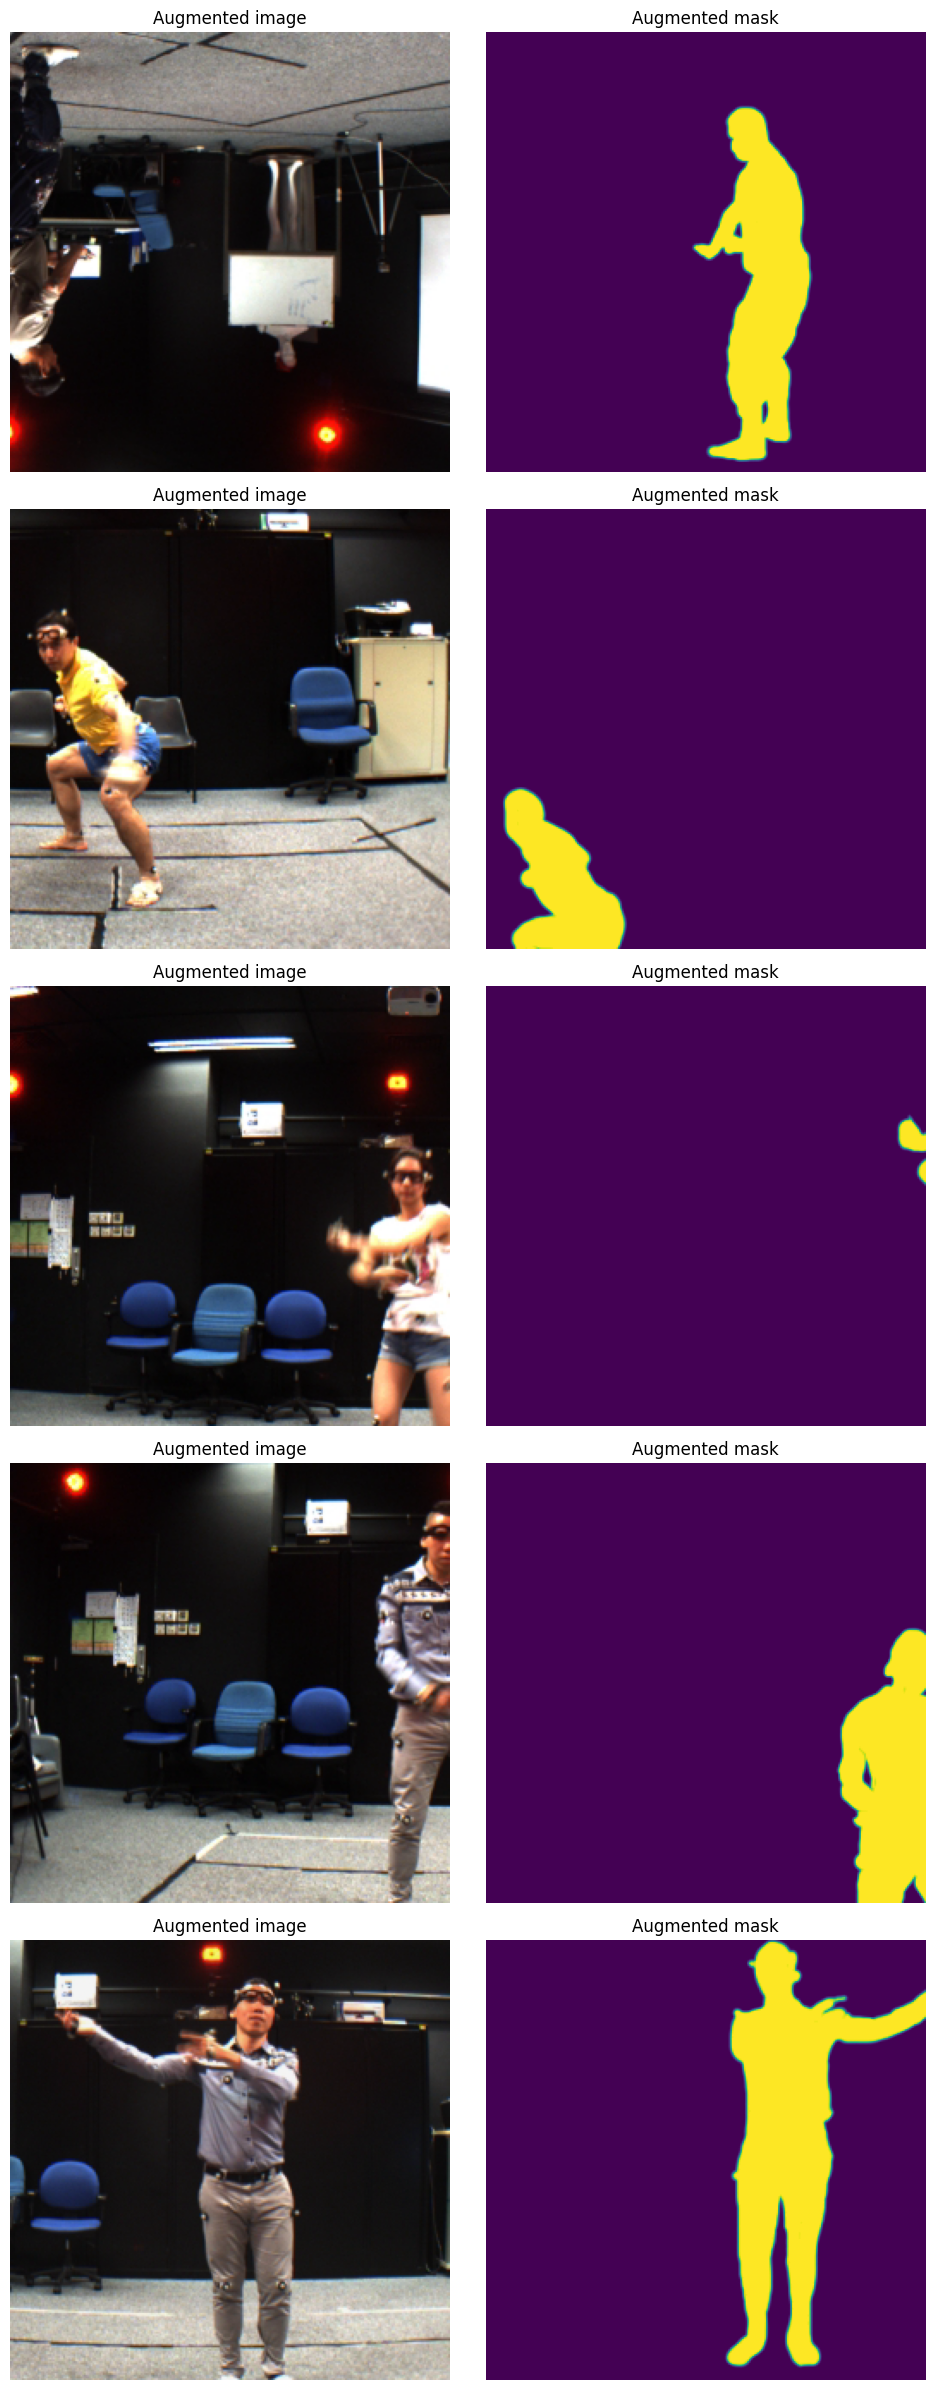

In [ ]:
image_visualization(path=train_set, NROWS=5)

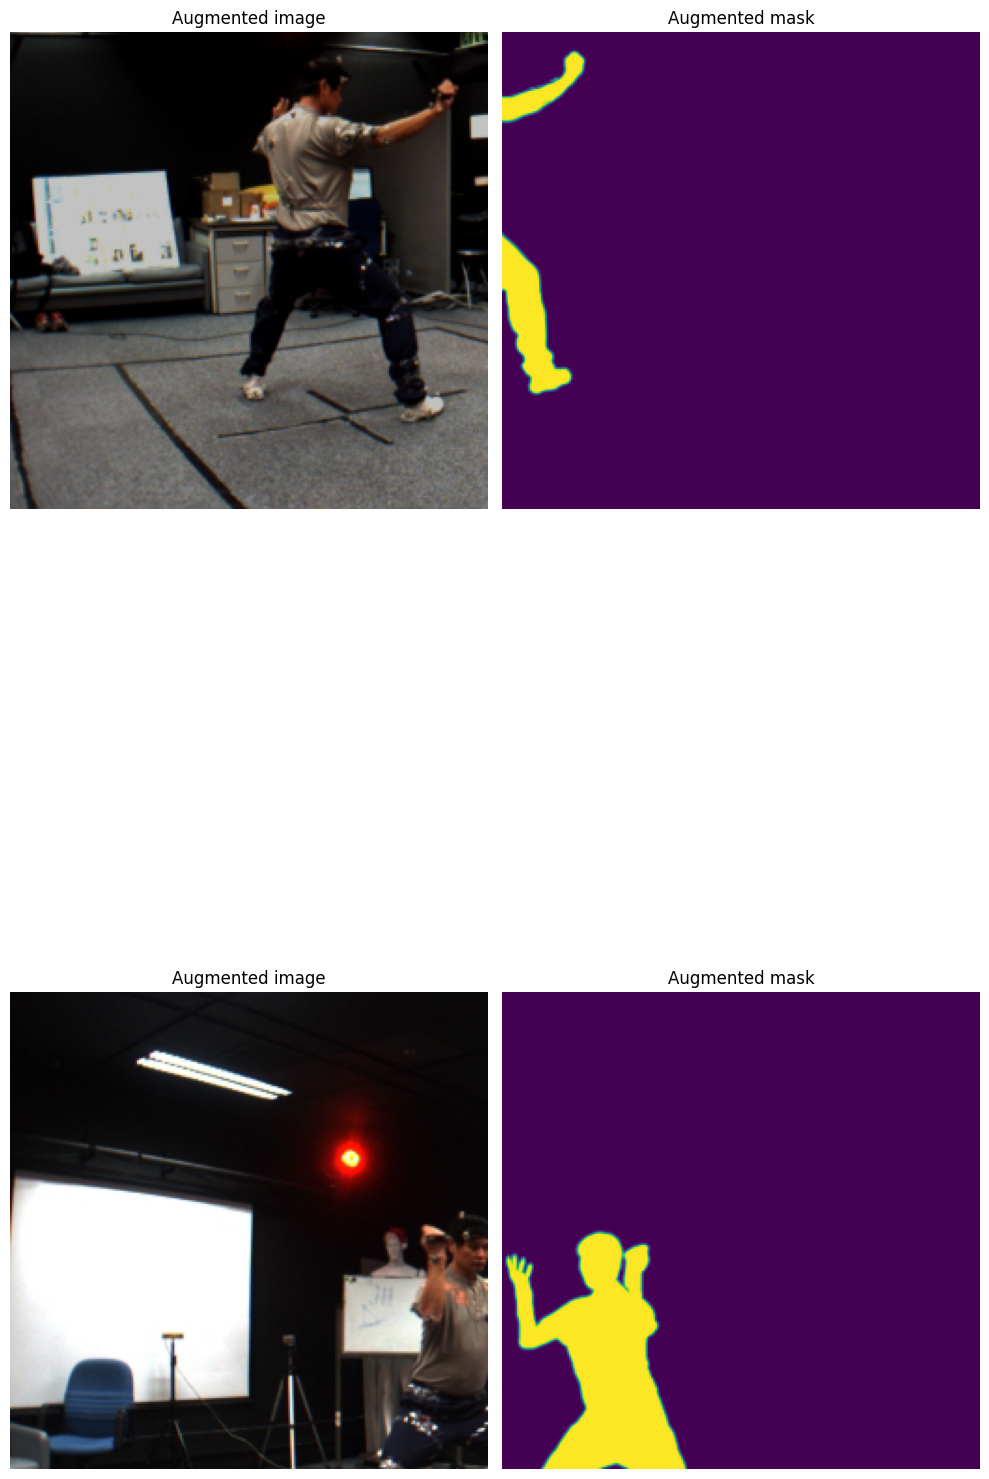

In [ ]:
image_visualization(path=test_set, NROWS=2)

### Dataloader

Загрузим изображения в даталоадер. Размер батча будет равен 16

In [ ]:
train_set = MyDataset(images_path=train_images, masks_path=train_masks, transform=train_transforms)
test_set = MyDataset(images_path=test_images, masks_path=test_masks, transform=test_transforms)


BATCH_SIZE = 16

train_loader = torch.utils.data.DataLoader(
    train_set,
    shuffle=True, 
    batch_size=BATCH_SIZE,
    num_workers=1,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    shuffle=True, 
    batch_size=BATCH_SIZE,
    num_workers=1
)



In [ ]:
for sample in train_loader:
  
  print(sample['image'].shape)
  print(sample['mask'].shape)
  break

torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])


## Создание модели

Напишем своими руками сеть ***Unet***, архитектура которой представлена ниже

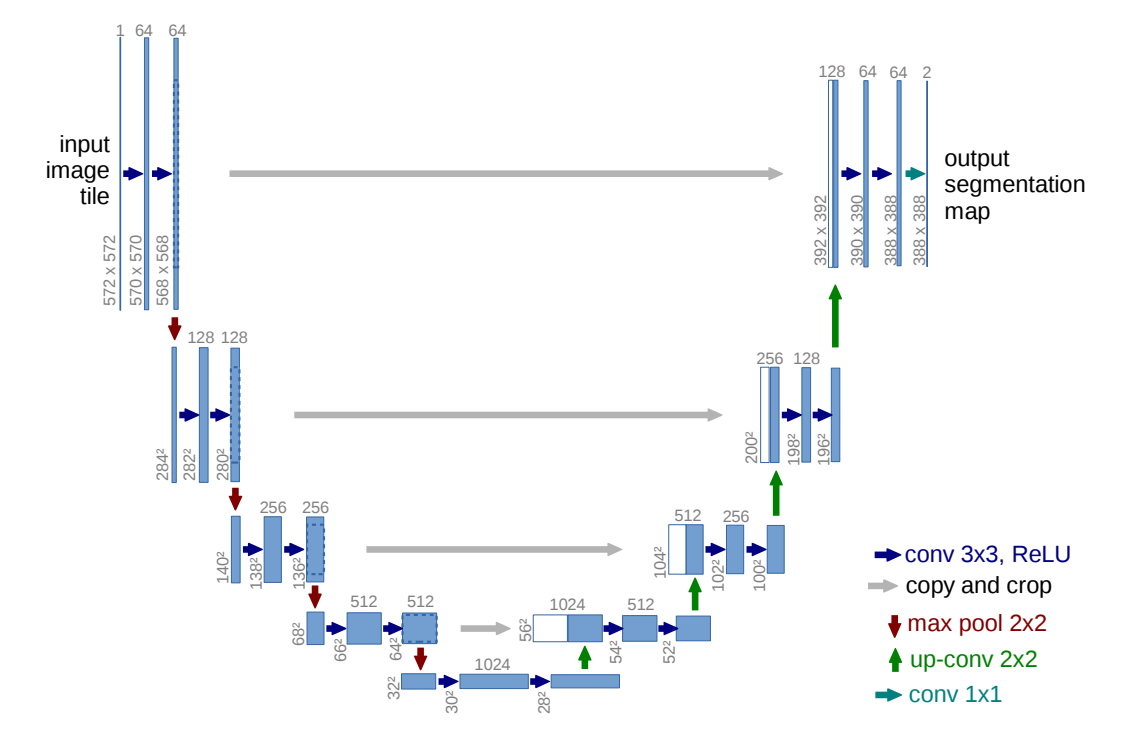

### CNN_block

Это блок, который на рисунке обозначен синей стрелкой. Здесь тензор проходит через два фильтра *(3,3)*, функцию активации ***ReLU*** и ***BatchNorm***

In [ ]:
class CNN_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size = 3, padding=1) # padding=1 оставляет размер изображения таким же после выхода из этого блока
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size =3, padding=1) # паддинги необходимы для того, чтобы потом в skip-connection
                                                                        # подать тензоры одинаковых размеров
                                                  
        self.BN = nn.BatchNorm2d(out_c)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.BN(x)
        x = self.ReLU(x)

        x = self.conv2(x)
        x = self.BN(x)
        out = self.ReLU(x) 
        
        return out

### ENCODER

Здесь мы реализуем проход по блоку, который задали выше, а также пропускаем через ***Maxpool*** *(2,2)*


Downsampling

In [ ]:
class encoder(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2)
        self.CNN_block1 = CNN_block(in_c, out_c)
        
    def forward(self, x):
      
        x = self.CNN_block1(x)
        out = self.Maxpool(x)

        return x, out



Будем возвращать тензор до пулинга и после. Тензор до пулинга необходим для конкатенации с тензором из блока ***decoder*** (***skip connection***)

### DECODER

Необходимо восстановить размеры изображений. Подходов есть несколько. Как вариант можно использовать интерполяцию, а после свертку *1x1*. В ***Pytorch*** есть функция ***nn.Upsample***, где в качестве параметра можно указать будущий размер картинки, а также вид интерполяции.

Но я решил использовать ***nn.ConvTranspose2d***. Это свертка, которая проходит через каждый пиксель изображения, увеличивая изображение. На рисунке ниже проиллюстрировано как работает эта свертка с различными страйдами  

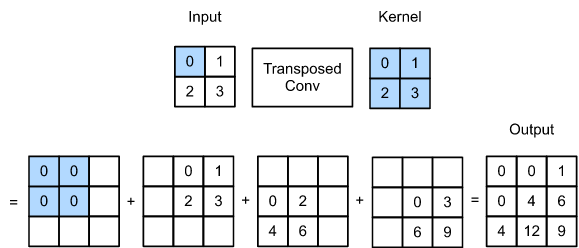

А вот если ***stride*** увеличить

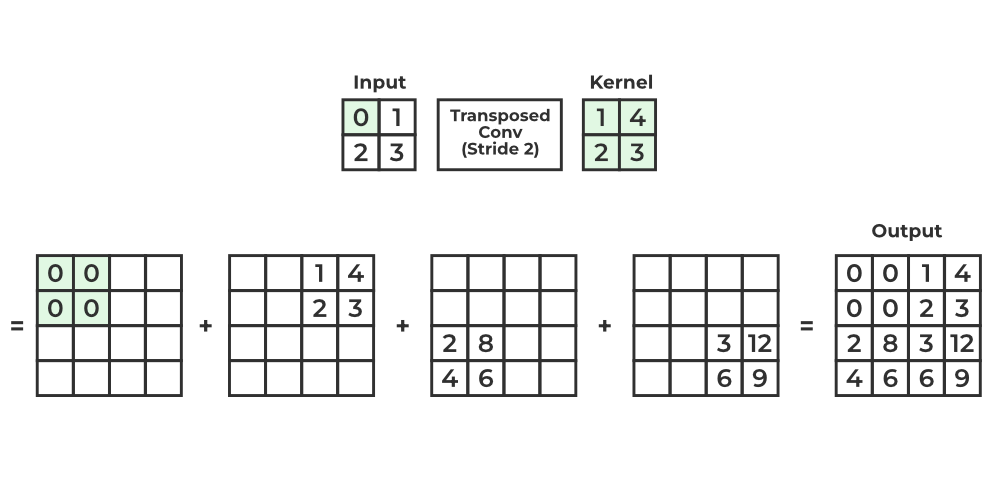

In [ ]:
class decoder(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = CNN_block(out_c + out_c, out_c)

    def forward(self, x, skip):
        x = self.up(x)

        if x.shape != skip.shape:
            x = TF.resize(tensor=x, size=skip.shape[2:]) # подгоняем размеры выходного тензора если они не совпадают с размерами skip тензора 

        x = torch.cat((x, skip), dim=1)
        x = self.conv(x)

        
        return x

### UNET Architecture

Объединим все блоки в итоговую архитектуру

In [ ]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        """ Encoder """
        self.enc1 = encoder(3, 64)
        self.enc2 = encoder(64, 128)
        self.enc3 = encoder(128, 256)
        self.enc4 = encoder(256, 512)

        """ Center """
        self.c = CNN_block(512, 1024)
        
        """ Decoder """
        self.dec4 = decoder(1024, 512)
        self.dec3 = decoder(512, 256)
        self.dec2 = decoder(256, 128)
        self.dec1 = decoder(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        skip1, x = self.enc1(x)
        skip2, x = self.enc2(x)
        skip3, x = self.enc3(x)
        skip4, x = self.enc4(x)

        x = self.c(x)

        x = self.dec4(x, skip4)
        x = self.dec3(x, skip3)
        x = self.dec2(x, skip2)
        x = self.dec1(x, skip1)

        out = self.output(x)
        return out
      

Красота! Модель готова

## Обучение

Пропишем необходимые параметры для обучения

In [ ]:
model = Unet()

loss = nn.BCEWithLogitsLoss() # объединяет слой с сигмоидой и BCELoss в одном классе
Adam = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
sched = torch.optim.lr_scheduler.ExponentialLR(Adam, gamma = 0.6) # умножает каждую эпоху lr на 0.6

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Метрика

Будем использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold: float):
    SMOOTH = 1e-8
    outputs = (outputs > threshold).float()
    intersection = (outputs*labels).sum()  # Will be zero if Truth=0 or Prediction=0

    union = outputs.sum() + labels.sum()         # Will be zero if both are 0
    
    iou = 2 * (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # 0.5 будет служить порогом для предсказания
    #  torch.clamp(input, min=None, max=None, *, out=None)
    #  min(max(input, min_val), max_val)
    return iou  # 

***IoU*** метрика, к сожалению, на тесте выдает нулевые значения, хотя модель маски прорисовывает такого же качества, что и в обучении. Поэтому пропишем свою метрику, которая будет считать отношение правильно угаданных пикселей на общее кол-во пикселей в изображении

In [ ]:
def accuracy(outputs: torch.Tensor, labels:torch.Tensor, threshold:float):
    
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > threshold).float()
    correct = (outputs == labels).sum()
    
    num_pixels = torch.numel(labels)

    return correct/num_pixels

In [ ]:
def train(model, train_loader, test_loader, num_epochs, loss_fn, metric, optimizer, scheduler, threshold):
    
    model = model.to(device)
    
    for epoch in range(num_epochs):
        loss_val = 0
        acc_val = 0
        loss_val_test = 0
        acc_val_test = 0

        for sample in (pbar := tqdm(train_loader)):

            model.train()
            img = sample['image'].to(device)
            mask = sample['mask'].to(device)
            optimizer.zero_grad() # Обнулим градиенты весов

            pred = model(img)

            loss_value = loss_fn(pred, mask)
            loss_value.backward()
            loss_item = loss_value.item()
            loss_val += loss_item

            optimizer.step()

            dice = metric(pred, mask, threshold).float().mean().data.cpu()
            acc_val += dice
            
            pbar.set_description(f'loss: {loss_item:.5f}\ accuracy {dice:.3f}')  
        
        scheduler.step()

        for test_sample in test_loader:

            model.eval()
            
            X = test_sample['image'].to(device)
            y = test_sample['mask'].to(device)
            with torch.no_grad():
                test_pred = model(X)
            
            loss_value_test = loss_fn(test_pred, y).data.cpu()
            loss_item_test = loss_value_test.item()
            loss_val_test += loss_item_test

            test_dice = metric(test_pred, y, threshold).float().mean().data.cpu()
            acc_val_test += test_dice

            pbar.set_description(f'test loss: {loss_item_test:.5f}\ accuracy {test_dice:.3f}')
        
        print(f'EPOCH №{epoch + 1}')
        print(20*'--')
        print(f'train loss: {loss_val/(len(train_loader)):.2f}')
        print(f'train accuracy: {acc_val/(len(train_loader)):.2f}')
        print(30*'--')
        print(f'test loss: {loss_val_test/(len(test_loader)):.2f}')
        print(f'test accuracy: {acc_val_test/(len(test_loader)):.2f}')
        print(50*'--')


Обучим модель на 10 эпохах

In [ ]:
train(model=model,
      train_loader=train_loader,
      test_loader=test_loader,
      num_epochs=10,
      loss_fn=loss,
      metric=accuracy,
      optimizer=Adam,
      scheduler=sched,
      threshold=0.5)

loss: 0.17765\ accuracy 0.966: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]


EPOCH №1
----------------------------------------
train loss: 0.29
train accuracy: 0.94
------------------------------------------------------------
test loss: 0.54
test accuracy: 0.75
----------------------------------------------------------------------------------------------------


loss: 0.09578\ accuracy 0.980: 100%|██████████| 62/62 [00:50<00:00,  1.24it/s]


EPOCH №2
----------------------------------------
train loss: 0.12
train accuracy: 0.97
------------------------------------------------------------
test loss: 0.27
test accuracy: 0.93
----------------------------------------------------------------------------------------------------


loss: 0.06642\ accuracy 0.983: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]


EPOCH №3
----------------------------------------
train loss: 0.08
train accuracy: 0.98
------------------------------------------------------------
test loss: 0.21
test accuracy: 0.93
----------------------------------------------------------------------------------------------------


loss: 0.05596\ accuracy 0.977: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]


EPOCH №4
----------------------------------------
train loss: 0.06
train accuracy: 0.98
------------------------------------------------------------
test loss: 0.23
test accuracy: 0.93
----------------------------------------------------------------------------------------------------


loss: 0.05264\ accuracy 0.982: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]


EPOCH №5
----------------------------------------
train loss: 0.05
train accuracy: 0.98
------------------------------------------------------------
test loss: 0.24
test accuracy: 0.93
----------------------------------------------------------------------------------------------------


loss: 0.04623\ accuracy 0.988: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]


EPOCH №6
----------------------------------------
train loss: 0.05
train accuracy: 0.98
------------------------------------------------------------
test loss: 0.24
test accuracy: 0.93
----------------------------------------------------------------------------------------------------


loss: 0.04563\ accuracy 0.984: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]


EPOCH №7
----------------------------------------
train loss: 0.05
train accuracy: 0.98
------------------------------------------------------------
test loss: 0.25
test accuracy: 0.93
----------------------------------------------------------------------------------------------------


loss: 0.04490\ accuracy 0.984: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]


EPOCH №8
----------------------------------------
train loss: 0.05
train accuracy: 0.98
------------------------------------------------------------
test loss: 0.24
test accuracy: 0.93
----------------------------------------------------------------------------------------------------


loss: 0.04401\ accuracy 0.982: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]


EPOCH №9
----------------------------------------
train loss: 0.04
train accuracy: 0.98
------------------------------------------------------------
test loss: 0.26
test accuracy: 0.93
----------------------------------------------------------------------------------------------------


loss: 0.04322\ accuracy 0.988: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]


EPOCH №10
----------------------------------------
train loss: 0.04
train accuracy: 0.98
------------------------------------------------------------
test loss: 0.25
test accuracy: 0.93
----------------------------------------------------------------------------------------------------


### Сохранение модели на диск

In [ ]:
model_save_name = 'UNET.pt'
PATH = f"/content/drive/My Drive/My_save_models/Segmentation/{model_save_name}" 
torch.save(model.state_dict(), PATH)

## Предсказание

In [ ]:
model_save_name = 'UNET.pt'
PATH = f"/content/drive/My Drive/My_save_models/Segmentation/{model_save_name}" 
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Проиллюстрируем работу модели

In [ ]:
def example_visualization(path:str, NROWS:int, model):
    fig, ax = plt.subplots(nrows=NROWS, ncols=2, figsize=(10,24))
    random_numbers = np.random.choice(len(path), NROWS, replace=False)
    model = model.to(device)

    for i in range(NROWS):
        image = path[random_numbers[i]]['image']
        mask = path[random_numbers[i]]['mask']
        pred = model(image.unsqueeze(0).to(device))

        img =  np.transpose(image, (1,2,0))
        output = torch.sigmoid(pred).cpu().data.numpy()
        output = np.transpose(output[0], (1,2,0))

        ax[i,0].imshow(img)
        ax[i,1].imshow(output)

        ax[i,0].axis('off')
        ax[i,1].axis('off')

        ax[i,0].set_title('Image')
        ax[i,1].set_title(f'mask accuracy {accuracy(pred, mask.to(device), 0.5):.2f}')

    plt.tight_layout()
    plt.show()


Видно, что метрика завышает работу модели. Модель плохо прорисовывает границы между фоном и человеком 

In [ ]:
example_visualization(train_set, 5, model)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
example_visualization(test_set, 5, model)


Output hidden; open in https://colab.research.google.com to view.